## Notebook for formatting data frames for phase association
Source:
- https://github.com/kaiwenwang233/scoped_ML_tutorial?tab=readme-ov-file
- https://www.usgs.gov/software/hypoinverse-earthquake-location
- https://chatgpt.com/c/67491af9-aaf8-800c-82e9-1033e094d8d0
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JB014966

In [2]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from pnwstore.mseed import WaveformClient
from obspy import UTCDateTime
from obspy.core.stream import Stream
from obspy.clients.fdsn import Client
from tqdm import tqdm
import datetime 






### 1.3 Create a CSV file for picks for the association

### Format the files for HypoInverse and HypoDD
References: https://github.com/kaiwenwang233/scoped_ML_tutorial?tab=readme-ov-file

### Format the station files 

In [2]:
region = 'pnsn_nor'
df = pd.read_csv(f'../data/datasets_{region}/all_picks_all_years_for_assoc_{region}.csv',index_col=0)


In [3]:
TOFB = df[df['station_code']=='TOFB']

In [4]:
TOFB['station_network_code'].unique()

array([], dtype=object)

In [5]:
from obspy import read_inventory
from collections import defaultdict
import pandas as pd

client2 = Client("IRIS")
networks = pd.read_csv("../data/networks.csv")
networks = ','.join(list(networks['networks']))
starttime = UTCDateTime(year=2011, month=1, day=1)
endtime = UTCDateTime(year=2016, month=1, day=1)
inv = [] 
# inv = read_inventory("./stations/*.xml")
station_locs = defaultdict(dict)
# stations=inv


for station in df['station_code'].unique():
    inv += client2.get_stations(network=networks,
                                    station=station, channel="?H?", 
                                    starttime=starttime, endtime=endtime, level="response")
stations=inv

print(len(stations))

for network in stations:
    print(network)
    for station in network:
        print(station)
        has_HH = bool(station.select(channel="HH?"))
        has_BH = bool(station.select(channel="BH?"))

        # Apply selection logic based on channel presence
        if has_HH and has_BH:
            # If both HH and BH channels are present, select only HH
            selected_station = station.select(channel="HH?")
        elif has_HH:
            # If only HH channels are present
            selected_station = station.select(channel="HH?")
        elif has_BH:
            # If only BH channels are present
            selected_station = station.select(channel="BH?")

        for chn in selected_station:
            print('This is chn: ', chn)
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict
            if station_locs[sid]["component"]=='Z':
                station_locs[sid]["response"]= f"0,0,"+station_locs[sid]["response"]
            elif station_locs[sid]["component"]=='N,Z':
                station_locs[sid]["response"]= f"0,"+station_locs[sid]["response"]
station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs["id"] = station_locs.index
station_locs = station_locs.rename_axis('station').reset_index()
station_locs.to_csv(f"./stations_{region}.csv",sep='\t')
station_locs

13
Network TA (USArray Transportable Array (EarthScope_TA))
	Station Count: 1/1893 (Selected/Total)
	2003-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (1):
			TA.I02D (Swisshome, OR, USA)
		Channels (15):
			TA.I02D..BHZ, TA.I02D..BHN, TA.I02D..BHE, TA.I02D..HHZ, 
			TA.I02D..HHN, TA.I02D..HHE, TA.I02D..LHZ, TA.I02D..LHN, 
			TA.I02D..LHE, TA.I02D..UHZ, TA.I02D..UHN, TA.I02D..UHE, 
			TA.I02D..VHZ, TA.I02D..VHN, TA.I02D..VHE
Station I02D (Swisshome, OR, USA)
	Station Code: I02D
	Channel Count: 15/55 (Selected/Total)
	2010-08-07T00:00:00.000000Z - 2015-10-22T23:59:59.000000Z
	Access: open 
	Latitude: 44.1059, Longitude: -123.8469, Elevation: 109.0 m
	Available Channels:
	    ..HH[ZNE]   100.0 Hz  2015-10-16 to 2015-10-22
	    ..BH[ZNE]    40.0 Hz  2010-08-07 to 2015-10-22
	    ..LH[ZNE]     1.0 Hz  2010-08-07 to 2015-10-22
	    ..VH[ZNE]     0.1 Hz  2010-08-07 to 2015-10-22
	    ..UH[ZNE]     0.0 Hz  2010-08-07 to 2015-10-22

This is chn:  Channel 'HHE', Location '' 


station   longitude   latitude  elevation(m)    component  \
0   TA.I02D..HH -123.846901  44.105900         109.0        E,N,Z   
1   7D.G03D..BH -126.161201  40.058701       -4056.5        1,2,Z   
2   TA.G03D..HH -123.264099  45.211498         222.0        E,N,Z   
3   UW.HEBO..BH -123.755390  45.213500         875.0  E,E,N,N,Z,Z   
4   UW.TAKO..BH -124.082474  43.743340          46.0        E,N,Z   
5    UO.DBO..BH -123.244423  43.118721         957.0  E,E,N,N,Z,Z   
6   TA.I03D..HH -123.348701  43.697201         140.0        E,N,Z   
7   TA.K02D..HH -123.665398  42.695499         989.0        E,N,Z   
8   TA.J01D..BH -123.931396  43.161400         131.0        E,N,Z   
9   UW.BABR..BH -123.789240  44.621320         438.7        E,N,Z   
10  UW.JEDS..BH -124.049050  43.751570         159.5        E,N,Z   
11  TA.J01E..HH -123.931396  43.161499         128.0        E,N,Z   
12  TA.I02E..HH -123.847298  44.107700         117.0        E,N,Z   

                                             response unit           id  
0              502116000.00,502116000.00,502116000.00  m/s  TA.I02D..HH  
1              313645000.00,313645000.00,313645000.00  m/s  7D.G03D..BH  
2              502116000.00,502116000.00,502116000.00  m/s  TA.G03D..HH  
3   419430000.00,754955000.00,419430000.00,7549550...  m/s  UW.HEBO..BH  
4              419430000.00,419430000.00,419430000.00  m/s  UW.TAKO..BH  
5   1048768000.00,754954800.00,1048768000.00,75495...  m/s   UO.DBO..BH  
6              502116000.00,502116000.00,502116000.00  m/s  TA.I03D..HH  
7              502116000.00,502116000.00,502116000.00  m/s  TA.K02D..HH  
8              502065000.00,502065000.00,502065000.00  m/s  TA.J01D..BH  
9              754364000.00,754364000.00,754364000.00  m/s  UW.BABR..BH  
10             754364000.00,754364000.00,754364000.00  m/s  UW.JEDS..BH  
11             502116000.00,502116000.00,502116000.00  m/s  TA.J01E..HH  
12             502116000.00,502116000.00,502116000.00  m/s  TA.I02E..HH

### Convert the station file from a CSV file to dat files

In [6]:
stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")
converted_hypoinverse = []
converted_hypoDD = {}

for i in tqdm(range(len(stations))):

    network_code, station_code, comp_code, channel_code = stations.iloc[i]['station'].split('.')
    station_weight = " "
    lat_degree = int(stations.iloc[i]['latitude'])
    lat_minute = (stations.iloc[i]['latitude'] - lat_degree) * 60
    north = "N" if lat_degree >= 0 else "S"
    lng_degree = int(stations.iloc[i]['longitude'])
    lng_minute = (stations.iloc[i]['longitude'] - lng_degree) * 60
    west = "W" if lng_degree <= 0 else "E"
    elevation = stations.iloc[i]['elevation(m)']
    line_hypoinverse = f"{station_code:<5} {network_code:<2} {comp_code[:-1]:<1}{channel_code:<3} {station_weight}{abs(lat_degree):2.0f} {abs(lat_minute):7.4f}{north}{abs(lng_degree):3.0f} {abs(lng_minute):7.4f}{west}{elevation:4.0f}\n"
    converted_hypoinverse.append(line_hypoinverse)
    converted_hypoDD[f"{station_code}"] = f"{network_code:<2}{station_code:<5} {stations.iloc[i]['latitude']:.3f} {stations.iloc[i]['longitude']:.3f} {elevation:4.0f}\n"

out_file = f'stations_hypoinverse_{region}.dat'
with open(out_file, 'w') as f:
    f.writelines(converted_hypoinverse)

out_file = f'stations_hypoDD_{region}.dat'
with open(out_file, 'w') as f:
    for k, v in converted_hypoDD.items():
        f.write(v)

100%|██████████| 13/13 [00:00<00:00, 5147.84it/s]


### Format the pick files

In [7]:
# Load necessary files
# Load all event data into a list of DataFrames
import datetime 
pick_assignment_files = [
    f'../data/datasets_{region}/all_pick_assignments_{region}.csv'
]

# Read all event files into DataFrames
dfs = [pd.read_csv(file, index_col=0) for file in pick_assignment_files]

# Concatenate all DataFrames into a single DataFrame
assignments =  pd.concat(dfs)

assignments = assignments.rename(columns={"time": "origin_time"})
assignments['origin_time'] = pd.to_datetime(assignments['origin_time'], utc = True)
assignments["pick_time"] = assignments["time_pick"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
assignments = assignments.sort_values(by='origin_time').reset_index(drop=True)

# Reset the idx column so that each group with the same 'time' has a new numbered event index
assignments['idx'] = assignments.groupby('origin_time').ngroup()


# picks = pd.read_csv(f'../data/datasets_{region}/all_picks_all_years_for_assoc_{region}.csv',index_col=0)
# picks = picks.sort_values(by='trace_start_time').reset_index(drop=True)


In [8]:
assignments

idx                      origin_time           x           y  \
0         0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
1         0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
2         0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
3         0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
4         0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
...     ...                              ...         ...         ...   
17410  1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   
17411  1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   
17412  1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   
17413  1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   
17414  1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   

               z  picks   latitude   longitude      depth  event_idx  \
0      12.890625      6  45.818856 -122.865754  12.890625          0   
1      12.890625      6  45.818856 -122.865754  12.890625          0   
2      12.890625      6  45.818856 -122.865754  12.890625          0   
3      12.890625      6  45.818856 -122.865754  12.890625          0   
4      12.890625      6  45.818856 -122.865754  12.890625          0   
...          ...    ...        ...         ...        ...        ...   
17410  19.140625      7  45.214211 -124.498723  19.140625       2414   
17411  19.140625      7  45.214211 -124.498723  19.140625       2414   
17412  19.140625      7  45.214211 -124.498723  19.140625       2414   
17413  19.140625      7  45.214211 -124.498723  19.140625       2414   
17414  19.140625      7  45.214211 -124.498723  19.140625       2414   

       pick_idx  residual station phase     time_pick   pick_id  \
0            11  0.523714    G03D     P  1.293892e+09       466   
1        288613 -0.286362    G03D     S  1.293892e+09       474   
2             5 -0.012461    I02D     P  1.293892e+09       252   
3        288602  0.100514    I02D     S  1.293892e+09       237   
4           250 -0.429837    I03D     P  1.293892e+09      4490   
...         ...       ...     ...   ...           ...       ...   
17410    512959 -0.050860    BABR     S  1.451537e+09  23571049   
17411    288553 -0.153992    G03D     P  1.451537e+09  23570522   
17412    512934  0.145829    G03D     S  1.451537e+09  23570561   
17413    288595  0.306746    HEBO     P  1.451537e+09  23570968   
17414    288431  0.124878    I02E     P  1.451537e+09  23569389   

                             pick_time  
0     2011-01-01 14:29:21.425001+00:00  
1     2011-01-01 14:29:29.625001+00:00  
2     2011-01-01 14:29:40.425000+00:00  
3     2011-01-01 14:30:03.850000+00:00  
4     2011-01-01 14:29:44.349998+00:00  
...                                ...  
17410 2015-12-31 04:49:54.665000+00:00  
17411 2015-12-31 04:49:45.670000+00:00  
17412 2015-12-31 04:49:57.540000+00:00  
17413 2015-12-31 04:49:40.460000+00:00  
17414 2015-12-31 04:49:51.430000+00:00  

[17415 rows x 17 columns]

In [9]:
# Merge the picks and assignments DataFrames on the pick_id column

# Convert the datetime columns to datetime objects
# picks['trace_p_arrival'] = pd.to_datetime(picks['trace_p_arrival'])
# picks['trace_s_arrival'] = pd.to_datetime(picks['trace_s_arrival'])
assignments['pick_time'] = pd.to_datetime(assignments['pick_time'])

# picks = pd.merge(picks, assignments, left_on="pick_id", right_on="pick_id", how='left')

# # Fill NaN values and convert idx columns to integers
# picks = picks.fillna(-1).astype({'idx': int})

# # Rename columns for consistency
# picks = picks.rename(columns={"station_code": "id", "pick_time": "timestamp","phase":'type','idx':'event_index'})
# picks['type'] = picks['type'].str.lower()

# Rename columns for consistency
assignments = assignments.rename(columns={"station": "id", "pick_time": "timestamp","phase":'type','idx':'event_index'})
assignments['type'] = assignments['type'].str.lower()


In [10]:
# picks.to_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t", index=False,
#                     date_format='%Y-%m-%dT%H:%M:%S.%f',
#                     columns=["id", "timestamp", "type", "event_index"])
assignments.to_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t", index=False,
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["id", "timestamp", "type", "event_index"])

In [11]:
assignments

event_index                      origin_time           x           y  \
0                0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
1                0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
2                0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
3                0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
4                0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
...            ...                              ...         ...         ...   
17410         1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   
17411         1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   
17412         1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   
17413         1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   
17414         1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   

               z  picks   latitude   longitude      depth  event_idx  \
0      12.890625      6  45.818856 -122.865754  12.890625          0   
1      12.890625      6  45.818856 -122.865754  12.890625          0   
2      12.890625      6  45.818856 -122.865754  12.890625          0   
3      12.890625      6  45.818856 -122.865754  12.890625          0   
4      12.890625      6  45.818856 -122.865754  12.890625          0   
...          ...    ...        ...         ...        ...        ...   
17410  19.140625      7  45.214211 -124.498723  19.140625       2414   
17411  19.140625      7  45.214211 -124.498723  19.140625       2414   
17412  19.140625      7  45.214211 -124.498723  19.140625       2414   
17413  19.140625      7  45.214211 -124.498723  19.140625       2414   
17414  19.140625      7  45.214211 -124.498723  19.140625       2414   

       pick_idx  residual    id type     time_pick   pick_id  \
0            11  0.523714  G03D    p  1.293892e+09       466   
1        288613 -0.286362  G03D    s  1.293892e+09       474   
2             5 -0.012461  I02D    p  1.293892e+09       252   
3        288602  0.100514  I02D    s  1.293892e+09       237   
4           250 -0.429837  I03D    p  1.293892e+09      4490   
...         ...       ...   ...  ...           ...       ...   
17410    512959 -0.050860  BABR    s  1.451537e+09  23571049   
17411    288553 -0.153992  G03D    p  1.451537e+09  23570522   
17412    512934  0.145829  G03D    s  1.451537e+09  23570561   
17413    288595  0.306746  HEBO    p  1.451537e+09  23570968   
17414    288431  0.124878  I02E    p  1.451537e+09  23569389   

                             timestamp  
0     2011-01-01 14:29:21.425001+00:00  
1     2011-01-01 14:29:29.625001+00:00  
2     2011-01-01 14:29:40.425000+00:00  
3     2011-01-01 14:30:03.850000+00:00  
4     2011-01-01 14:29:44.349998+00:00  
...                                ...  
17410 2015-12-31 04:49:54.665000+00:00  
17411 2015-12-31 04:49:45.670000+00:00  
17412 2015-12-31 04:49:57.540000+00:00  
17413 2015-12-31 04:49:40.460000+00:00  
17414 2015-12-31 04:49:51.430000+00:00  

[17415 rows x 17 columns]

### Format event files

In [12]:
catalog = assignments.drop_duplicates(subset='event_idx')

In [13]:
catalog = catalog.rename(columns={'origin_time':'time',"depth": "depth_km",'idx':'event_index'})


In [14]:
catalog

event_index                             time           x           y  \
0                0 2011-01-01 14:29:08.592014+00:00  204.720304  149.947081   
6                1 2011-01-02 06:00:27.305558+00:00  -45.183500 -399.327271   
16               2 2011-01-02 22:40:11.836734+00:00   -0.557821 -417.922496   
27               3 2011-01-03 07:08:41.304047+00:00  245.999058 -194.779791   
34               4 2011-01-03 07:49:16.234826+00:00  106.543810 -435.087320   
...            ...                              ...         ...         ...   
17373         1955 2015-12-29 03:43:24.837764+00:00   -0.557821 -376.440840   
17379         1956 2015-12-29 21:21:55.243515+00:00   73.074550 -415.061693   
17387         1957 2015-12-30 07:40:58.988172+00:00  148.938205   41.236532   
17395         1958 2015-12-30 14:56:11.991395+00:00 -109.890736 -136.133311   
17408         1959 2015-12-31 04:49:30.017555+00:00   78.652760   79.857385   

               z  picks   latitude   longitude   depth_km  event_idx  \
0      12.890625      6  45.818856 -122.865754  12.890625          0   
6       0.390625     10  40.904027 -126.036256   0.390625          1   
16     24.609375     11  40.737825 -125.506604  24.609375          2   
27      5.859375      7  42.707510 -122.497438   5.859375          3   
34     12.109375      9  40.576400 -124.241697  12.109375          4   
...          ...    ...        ...         ...        ...        ...   
17373  37.890625      6  41.111357 -125.506641  37.890625       2410   
17379  26.953125      8  40.760342 -124.634595  26.953125       2411   
17387  37.890625      8  44.855534 -123.615775  37.890625       2412   
17395   8.203125     13  43.266780 -126.853538   8.203125       2413   
17408  19.140625      7  45.214211 -124.498723  19.140625       2414   

       pick_idx  residual    id type     time_pick   pick_id  \
0            11  0.523714  G03D    p  1.293892e+09       466   
6        288732  0.771052  TAKO    s  1.293948e+09      5654   
16       288736  1.606632  TAKO    s  1.294008e+09      5658   
27          834 -0.416701  K02D    p  1.294039e+09     13160   
34          543  0.228204  J01D    p  1.294041e+09      8546   
...         ...       ...   ...  ...           ...       ...   
17373    288087  0.164174   DBO    p  1.451361e+09  23566170   
17379    512587 -0.041240  J01E    s  1.451424e+09  23565484   
17387    512748 -0.695511  K02D    s  1.451461e+09  23567374   
17395    512705  0.004558  K02D    s  1.451487e+09  23567059   
17408    512945 -0.234406  HEBO    s  1.451537e+09  23570966   

                             timestamp  
0     2011-01-01 14:29:21.425001+00:00  
6     2011-01-02 06:01:58.966000+00:00  
16    2011-01-02 22:41:40.346000+00:00  
27    2011-01-03 07:08:56.699998+00:00  
34    2011-01-03 07:49:59.125000+00:00  
...                                ...  
17373 2015-12-29 03:44:06.380000+00:00  
17379 2015-12-29 21:23:03.660000+00:00  
17387 2015-12-30 07:41:58.500000+00:00  
17395 2015-12-30 14:57:22.100000+00:00  
17408 2015-12-31 04:49:47.335000+00:00  

[1960 rows x 17 columns]

In [15]:
catalog.to_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv', sep="\t", index=False,
                    float_format="%.3f",
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["time", "longitude", "latitude", "depth_km",'event_index'])

In [16]:
events = pd.read_csv(f'../data/datasets_nwa_shelf_trench/events_nwa_shelf_trench.csv', index_col=0)
events

idx                              time           x           y          z  \
0      0  2011-01-02 02:10:45.481987+00:00   19.523735  523.281993  49.609375   
8      8  2011-01-03 22:30:53.445832+00:00  -78.652760  277.252856  12.890625   
10    10  2011-01-05 05:25:45.145580+00:00  -97.618674  461.774708   4.296875   
11    11  2011-01-05 09:29:58.041704+00:00  -92.040464  551.890032  24.609375   
12    12  2011-01-05 14:35:15.536295+00:00 -290.624737  559.042042   5.078125   
..   ...                               ...         ...         ...        ...   
266  266  2014-05-04 09:37:25.896488+00:00 -306.243725  507.547571  13.671875   
273  273  2014-05-21 04:04:16.795543+00:00  -77.537118  533.294806  41.796875   
275  275  2014-05-25 11:21:40.359990+00:00  232.611354  414.571444  49.609375   
276  276  2014-05-27 08:51:10.491000+00:00 -285.046527  507.547571  11.328125   
277  277  2014-05-27 22:09:54.035500+00:00 -285.046527  497.534757   7.421875   

     picks   latitude   longitude      depth  
0       10  49.206819 -125.232068  49.609375  
8        6  46.989816 -126.533950  12.890625  
10       6  48.646430 -126.824766   4.296875  
11       7  49.457391 -126.769550  24.609375  
12       6  49.459134 -129.509297   5.078125  
..     ...        ...         ...        ...  
266      6  48.989699 -129.684922  13.671875  
273     10  49.292245 -126.565918  41.796875  
275      7  48.186967 -122.371453  49.609375  
276      8  48.999834 -129.395983  11.328125  
277      6  48.910006 -129.388983   7.421875  

[123 rows x 9 columns]

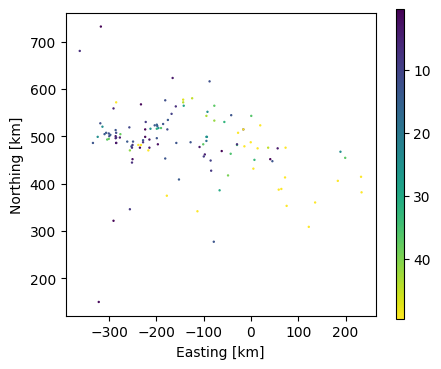

In [17]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],s=0.5,cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

In [18]:
catalog = pd.read_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv',index_col=0)
len(catalog)

1960

In [54]:
from datetime import datetime


stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")
stations['net'] = stations['station'].apply(lambda x: x.split('.')[0])
stations['sta'] = stations['station'].apply(lambda x: x.split('.')[1])
stations['cha'] = stations['station'].apply(lambda x: x.split('.')[3])

picks = pd.read_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t")
events = pd.read_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv', sep="\t")

events["match_id"] = events["event_index"]
picks["match_id"] = picks["event_index"]
events.sort_values(by="time", inplace=True, ignore_index=True)

out_file = open(f"../hypoInv/hypoInput_{region}.arc", "w")

events['time'] = pd.to_datetime(events['time'])

picks_by_event = picks.groupby("match_id").groups
for i in tqdm(range(len(events))):
    # 2011-01-01 14:29:08.592014
    event = events.iloc[i]
    event_time = datetime.strftime(event["time"],"%Y%m%d%H%M%S%f")[:-4]
    lat_degree = int(event["latitude"])
    lat_minute = (event["latitude"] - lat_degree) * 60 * 100
    south = "S" if lat_degree <= 0 else " "
    lng_degree = int(event["longitude"])
    lng_minute = (event["longitude"] - lng_degree) * 60 * 100
    east = "E" if lng_degree >= 0 else " "
    depth = event["depth_km"]
    if np.sum(picks[picks["event_index"] == events.iloc[i]['match_id']]['type'] == 'p') == 0:
        continue
    event_line = f"{event_time}{abs(lat_degree):2d}{south}{abs(lat_minute):4.0f}{abs(lng_degree):3d}{east}{abs(lng_minute):4.0f}{int(depth * 100):5d}"
    out_file.write(event_line + "\n")

    picks_idx = picks_by_event[event["match_id"]]
    for j in picks_idx:
        pick = picks.iloc[j]
        station_code = pick['id']
        network_code = stations['net'][stations['sta'] == pick['id']].iloc[0]
        comp_code = ''
        channel_code = stations['cha'][stations['sta'] == pick['id']].iloc[0]
        phase_type = pick['type']
        
        # Check if 'prob' column exists
        if 'prob' in pick:
            phase_weight = min(max(int((1 - pick['prob']) / (1 - 0.3) * 4) - 1, 0), 3)
        else:
            phase_weight = 0  # Default value if 'prob' column is missing
        # 2011-01-02 02:11:06.849100+00:00
        # Assuming pick['timestamp'] has the format '2012-01-01 03:19:00.689664+00:00'
        try:
            pick_time = datetime.strptime(pick["timestamp"], "%Y-%m-%dT%H:%M:%S.%f")  # Handle timezone with %z
        except:
            pick_time = datetime.strptime(pick["timestamp"], "%Y-%m-%dT%H:%M:%S%z")  # Handle timezone with %z
        phase_time_minute = pick_time.strftime("%Y%m%d%H%M")  # Extract YYYYMMDDHHMM
        phase_time_second = pick_time.strftime("%S%f")[:-4]  # Extract seconds with first two digits of microseconds
        tmp_line = f"{station_code:<5}{network_code:<2} {comp_code:<1}{channel_code:<3}"
        if phase_type.upper() == 'P':
            pick_line = f"{tmp_line:<13} P {phase_weight:<1d}{phase_time_minute} {phase_time_second}"
        elif phase_type.upper() == 'S':
            pick_line = f"{tmp_line:<13}   4{phase_time_minute} {'':<12}{phase_time_second} S {phase_weight:<1d}"
        else:
            raise ValueError(f"Phase type error {phase_type}")
        out_file.write(pick_line + "\n")
    terminator_line = f"{'    '}{'  '}{event_time[8:12]}{event_time[12:16]}{abs(lat_degree):2d}{' '}{abs(lat_minute):4.0f}{abs(lng_degree):3d}{abs(lng_minute):4.0f}{int(depth * 100):5d}"
    out_file.write(terminator_line+'\n')
    # out_file.write("\n")
    if i > 1e5:
        break

out_file.close()

  0%|          | 0/1960 [00:00<?, ?it/s]

100%|██████████| 1960/1960 [00:03<00:00, 516.64it/s]


In [32]:
region = 'pnsn_nor'
events = pd.read_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv', sep="\t")
events

time  longitude  latitude  depth_km  event_index
0     2011-01-01T14:29:08.592014   -122.866    45.819    12.891            0
1     2011-01-02T06:00:27.305558   -126.036    40.904     0.391            1
2     2011-01-02T22:40:11.836734   -125.507    40.738    24.609            2
3     2011-01-03T07:08:41.304047   -122.497    42.708     5.859            3
4     2011-01-03T07:49:16.234826   -124.242    40.576    12.109            4
...                          ...        ...       ...       ...          ...
1955  2015-12-29T03:43:24.837764   -125.507    41.111    37.891         1955
1956  2015-12-29T21:21:55.243515   -124.635    40.760    26.953         1956
1957  2015-12-30T07:40:58.988172   -123.616    44.856    37.891         1957
1958  2015-12-30T14:56:11.991395   -126.854    43.267     8.203         1958
1959  2015-12-31T04:49:30.017555   -124.499    45.214    19.141         1959

[1960 rows x 5 columns]

In [33]:
events['time'] = pd.to_datetime(events['time'])
events

time  longitude  latitude  depth_km  event_index
0    2011-01-01 14:29:08.592014   -122.866    45.819    12.891            0
1    2011-01-02 06:00:27.305558   -126.036    40.904     0.391            1
2    2011-01-02 22:40:11.836734   -125.507    40.738    24.609            2
3    2011-01-03 07:08:41.304047   -122.497    42.708     5.859            3
4    2011-01-03 07:49:16.234826   -124.242    40.576    12.109            4
...                         ...        ...       ...       ...          ...
1955 2015-12-29 03:43:24.837764   -125.507    41.111    37.891         1955
1956 2015-12-29 21:21:55.243515   -124.635    40.760    26.953         1956
1957 2015-12-30 07:40:58.988172   -123.616    44.856    37.891         1957
1958 2015-12-30 14:56:11.991395   -126.854    43.267     8.203         1958
1959 2015-12-31 04:49:30.017555   -124.499    45.214    19.141         1959

[1960 rows x 5 columns]

In [36]:
event_time = datetime.strftime(event["time"],"%Y%m%d%H%M%S%f")[:-4]

In [51]:
event_time[12:14]

'30'

In [52]:
event_time

'2015123104493001'